In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
!python -m spacy download en


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


!cat kaggle.json

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
#Download data
!kaggle competitions download -c quora-question-pairs

 94% 107M/114M [00:01<00:00, 80.0MB/s] 
100% 114M/114M [00:01<00:00, 97.1MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
 61% 13.0M/21.2M [00:00<00:00, 38.3MB/s]
100% 21.2M/21.2M [00:00<00:00, 60.9MB/s]
  0% 0.00/4.95M [00:00<?, ?B/s]
100% 4.95M/4.95M [00:00<00:00, 45.6MB/s]


In [6]:
!unzip -q train.csv.zip -d .


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
#from bs4 import BeautifulSoup

import spacy
import random

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator


In [8]:
df = pd.read_csv("/content/train.csv",encoding='latin-1')
df = df.fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
#df = df[0: 100000]

In [10]:
df.shape[0]

404290

In [11]:
spacy_text = spacy.load('en')


In [12]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [13]:
def tokenize_text(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_text.tokenizer(text)]

In [14]:

Q1 = Field(tokenize = tokenize_text,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)

Q2 = Field(tokenize = tokenize_text,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)

In [15]:
LABEL = data.LabelField(dtype = torch.float)

In [16]:
fields = [('q1', Q1), ('q2', Q2), ('label', LABEL)]

In [17]:
example = [torchtext.legacy.data.Example.fromlist([df.question1[i], df.question2[i], df.is_duplicate[i]], fields) for i in range(df.shape[0])]


In [18]:
Dataset = torchtext.legacy.data.Dataset(example, fields)


In [19]:
(train_data, valid_data) = Dataset.split(split_ratio= [0.8, 0.2], random_state = random.seed(SEED))
len(train_data), len(valid_data)

(323432, 80858)

In [20]:
#MAX_VOCAB_SIZE = 30_000

#Q1.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
#Q2.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
#LABEL.build_vocab(train_data)

In [21]:
#building vocabulary with words in both the question sets
MAX_VOCAB_SIZE = 60_000
Q1.build_vocab(train_data.q1, train_data.q2, 
               max_size = MAX_VOCAB_SIZE, 
               vectors = "glove.6B.300d", 
              unk_init = torch.Tensor.normal_)
Q2.vocab = Q1.vocab
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399584/400000 [00:34<00:00, 11196.57it/s]

we have to build vocabulary on both

In [22]:

print(f"Unique tokens in Question 1 vocabulary: {len(Q1.vocab)}")
print(f"Unique tokens in Question 2 vocabulary: {len(Q2.vocab)}")
print(f"Unique tokens in Label vocabulary: {len(LABEL.vocab)}")

Unique tokens in Question 1 vocabulary: 60004
Unique tokens in Question 2 vocabulary: 60004
Unique tokens in Label vocabulary: 2


In [23]:
print(vars(train_data[10]))

{'q1': ['is', 'nothing', 'free', 'in', 'this', 'world', '?'], 'q2': ['why', 'is', 'nothing', 'free', 'in', 'this', 'world', '?'], 'label': 0}


In [24]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.q1),
    device = device)

In [25]:
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx ):
    
    super().__init__()
    
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)

    
    
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    #print("Text shape : ", text.shape)
    embedded = self.dropout(self.embedding(text))
    #print("embedded shape : ", embedded.shape)
    #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
    outputs, (hidden, cell) = self.lstm(embedded)
    #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    #print("hidden1... ", hidden.shape)

    #hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
    #print("hidden2#... ", hidden.shape)
    #return self.fc2(self.fc1(hidden))
    hidden = hidden[-1, :, :].squeeze(0)
    return hidden



In [26]:
import torch.nn.functional as F

class SiameseLSTM(nn.Module):
  def __init__(self, encoder, device, hidden_dim, output_dim):
    super().__init__()
    self.encoder1 = encoder
    self.encoder2 = encoder
    self.device = device
    self.fc1 = nn.Linear(hidden_dim, 128)

    self.fc2 = nn.Linear(128, output_dim)
  def forward(self, q1, q2):
    output1 = self.encoder1(q1)
    output2 = self.encoder2(q2)
    output3 = torch.cat((F.relu(self.fc1(output1)), F.relu(self.fc1(output2))), dim =1)
    output4 = F.relu(self.fc1(output3))
    output5 =self.fc2(output4)
    #print(output1.shape, output2.shape, output3.shape, output4.shape, output5.shape)

    #distance
    #dist = torch.exp(- torch.sum(torch.abs(output1 - output2), dim=1, keepdim=True))
    #dist = torch.dist(output1, output2, p=2)
    return output5


In [27]:
INPUT_DIM = len(Q1.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = Q1.vocab.stoi[Q1.pad_token]

enc = Encoder(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM,
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)



In [28]:
model = SiameseLSTM(enc, device, HIDDEN_DIM, OUTPUT_DIM)

In [29]:
model.to(device)

100%|█████████▉| 399584/400000 [00:50<00:00, 11196.57it/s]

SiameseLSTM(
  (encoder1): Encoder(
    (embedding): Embedding(60004, 300, padding_idx=1)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder2): Encoder(
    (embedding): Embedding(60004, 300, padding_idx=1)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [30]:

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

SiameseLSTM(
  (encoder1): Encoder(
    (embedding): Embedding(60004, 300, padding_idx=1)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder2): Encoder(
    (embedding): Embedding(60004, 300, padding_idx=1)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [31]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,131,953 trainable parameters


In [32]:

#LEARNING_RATE = 0.003

#optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters())

In [33]:
criterion = nn.BCEWithLogitsLoss()


In [34]:
model = model.to(device)
criterion = criterion.to(device)

In [35]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [36]:
def train(model, iterator, optimizer, criterion): 
  model.train()
  epoch_loss = 0
  epoch_acc = 0

  

  for i, batch in enumerate(iterator):
    q1 = batch.q1
    q2 = batch.q2
    label = batch.label
    #print(q1, q2, label)

    maxsize = max(q1[0].shape, q2[0].shape)
    #print(maxsize)

    
    if q1.shape[1] < maxsize[0]:
      #print("padding q1")
      to_be_padded_shape = ( q1.shape[0], maxsize[0] - q1.shape[1])
      padding = torch.zeros(to_be_padded_shape, dtype=torch.int64, device=device)
      q1 = torch.cat((q1, padding), dim=1)
    else:
      #print("padding q2")
      to_be_padded_shape = ( q2.shape[0], maxsize[0] - q2.shape[1])
      padding = torch.zeros(to_be_padded_shape, dtype=torch.int64, device=device)
      q2 = torch.cat((q2, padding), dim=1)

   
    q2 = q2.to(device)
    optimizer.zero_grad()

    output = model(q1.permute(-1,0), q2.permute(-1,0)).squeeze(1)
    
    loss = criterion(output, label)
    acc = binary_accuracy(output, label)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
    
    #if (i%200 == 0):
    #  print(i, "  -  Loss: ", loss.item(), " ; Accuracy : ", acc.item())
  
  return epoch_loss / len(iterator), epoch_acc/len(iterator)


In [37]:
def evaluate(model, iterator, criterion): 
  model.eval()
  epoch_loss = 0
  epoch_acc = 0

  with torch.no_grad():
    
    for i, batch in enumerate(iterator):
      
      q1 = batch.q1
      q2 = batch.q2
      label = batch.label
      #print(q1, q2, label)

      maxsize = max(q1[0].shape, q2[0].shape)
      #print(maxsize)

      
      if q1.shape[1] < maxsize[0]:
        #print("padding q1")
        to_be_padded_shape = ( q1.shape[0], maxsize[0] - q1.shape[1])
        padding = torch.zeros(to_be_padded_shape, dtype=torch.int64, device=device)
        q1 = torch.cat((q1, padding), dim=1)
      else:
        #print("padding q2")
        to_be_padded_shape = ( q2.shape[0], maxsize[0] - q2.shape[1])
        padding = torch.zeros(to_be_padded_shape, dtype=torch.int64, device=device)
        q2 = torch.cat((q2, padding), dim=1)
      
      

      output = model(q1.permute(-1,0), q2.permute(-1,0)).squeeze(1)
      
      loss = criterion(output, label)
      acc = binary_accuracy(output, label)
      

      

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
      
  
  return epoch_loss / len(iterator), epoch_acc/len(iterator)


In [38]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
N_EPOCHS = 10

best_valid_loss = float('inf')
tloss = []
tacc=[]
vloss=[]
vacc=[]
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    tloss.append(train_loss)
    vloss.append(valid_loss)
    tacc.append(train_acc*100)
    vacc.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 54s
	Train Loss: 0.584 | Train Acc: 69.38%
	 Val. Loss: 0.542 |  Val. Acc: 73.28%
Epoch: 02 | Epoch Time: 1m 58s
	Train Loss: 0.468 | Train Acc: 77.63%
	 Val. Loss: 0.536 |  Val. Acc: 71.49%
Epoch: 03 | Epoch Time: 1m 58s
	Train Loss: 0.422 | Train Acc: 80.09%
	 Val. Loss: 0.458 |  Val. Acc: 78.59%
Epoch: 04 | Epoch Time: 1m 59s
	Train Loss: 0.381 | Train Acc: 82.23%
	 Val. Loss: 0.450 |  Val. Acc: 78.69%
Epoch: 05 | Epoch Time: 1m 58s
	Train Loss: 0.344 | Train Acc: 84.20%
	 Val. Loss: 0.475 |  Val. Acc: 77.60%
Epoch: 06 | Epoch Time: 1m 58s
	Train Loss: 0.314 | Train Acc: 85.77%
	 Val. Loss: 0.469 |  Val. Acc: 79.44%
Epoch: 07 | Epoch Time: 1m 58s
	Train Loss: 0.287 | Train Acc: 87.09%
	 Val. Loss: 0.477 |  Val. Acc: 79.91%
Epoch: 08 | Epoch Time: 1m 58s
	Train Loss: 0.265 | Train Acc: 88.14%
	 Val. Loss: 0.484 |  Val. Acc: 80.17%
Epoch: 09 | Epoch Time: 1m 59s
	Train Loss: 0.245 | Train Acc: 89.03%
	 Val. Loss: 0.490 |  Val. Acc: 80.06%
Epoch: 10 | Epoch T

In [40]:
import matplotlib.pyplot as plt

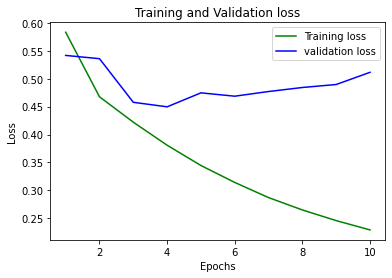

In [41]:
epochs = range(1,N_EPOCHS+1)
plt.plot(epochs, tloss, 'g', label='Training loss')
plt.plot(epochs, vloss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

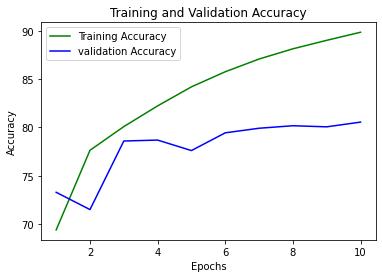

In [42]:
epochs = range(1,N_EPOCHS+1)
plt.plot(epochs, tacc, 'g', label='Training Accuracy')
plt.plot(epochs, vacc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_duplicates(model, question1, question2):
    model.eval()
    tokenized1 = [tok.text for tok in nlp.tokenizer(question1)]
    indexed1 = [Q1.vocab.stoi[t] for t in tokenized1]
    tokenized2 = [tok.text for tok in nlp.tokenizer(question2)]
    indexed2 = [Q2.vocab.stoi[t] for t in tokenized2]
    length1 = [len(indexed1)]
    lenfth2 = [len(indexed2)]
    tensor1 = torch.LongTensor(indexed1).to(device)
    tensor1 = tensor1.unsqueeze(1)
    tensor2 = torch.LongTensor(indexed2).to(device)
    tensor2 = tensor2.unsqueeze(1)
    print(tensor1.shape)
    #length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor1, tensor2))
    print(prediction)
    return prediction.item()

In [55]:
predict_duplicates(model, "How are you", "How are you")

torch.Size([3, 1])


IndexError: ignored